## Optimisation - or how to fit data

In this notebook, we will review briefly various concepts and Python tools that can be used to perform optimisation, model solving, and curve fitting.

***Dependencies***
- numpy
- scipy
- matplotlib
- uncertainties

Note: this notebook was originally written in collaboration with Oscar Branson (Cambridge) and Andrew Valentine (ANU-RSES) in the framework of the 'data surgeries' event from the Data Science research theme at RSES.

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

# Generating fake data: A simple curve fit with noise

We will fit a second order polynomial function, that can be calculate with the function defined below:

In [3]:
def my_polynomial(x,a,b,c):
    return a + x*b + c*x*x

Nous pouvons utiliser cette fonction pour générer de fausses données

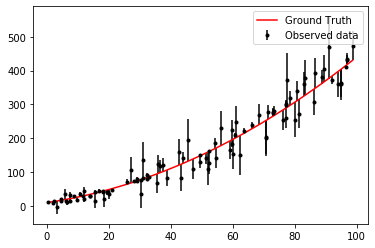

In [4]:
# true parameters
a = 10.0
b = 1.321
c = 0.02978

N = 100

x = np.sort(100*np.random.rand(N))
y = my_polynomial(x,a,b,c)

# Real world observations are noisy...
# but we had a bias in observations and we underestimate the errors
# observed ese are the sum of the two values
f = 0.5 # our systematic bias
ese = f*np.sqrt(y)*5*np.random.randn(N)

y_noisy = y + ese

plt.errorbar(x,y_noisy,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.legend()

# Fitting the data

We can guess look at the figure that the data follow some second order polynomial, or maybe a third. Simplicity is great, so we chose a second order polynomial.

The idea is now to define a model *m* which fits our data *d* with some parameters we can tune. We basically want to map:

$d = G(m)$ , eq. 1

In this case, our model is a second order polynomial function:

$d = a + b*x + c*x*x$ . eq. 2

An easy and well used way to fit our data with eq. 2 is to use **least-square regression**.

The least-square problem consists in minimizing the misfit between the observation $d$ and the model $m$:

$misfit = \sum_{i=1}^{n}{(d_n-m_n)^2}$ , eq. 3

We want to minimize this value. The eq. 3 is called the **objective function** of our problem.

There is several way to do that. In python, one of the simplest is to use the curve_fit function of scipy. In order to use this function, we need to have another one that allows calculating eq. 1. Let's do that.

In [5]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 
import uncertainties

# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(my_polynomial,x,y_noisy) 

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

print("Obtained parameters:")
print(popt)


Obtained parameters:
[9.89954352 1.22806876 0.03154804]


Fit RMSE is: 83205.38274653045


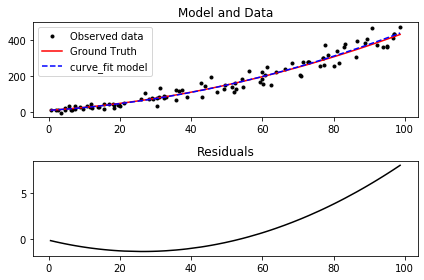

In [6]:
# we calculate the best estimate
y_pred_curvefit = my_polynomial(x,*popt) # parameter unwrapping (*popt) works only in Python 3

print("Fit RMSE is: "+str(np.sum((y_pred_curvefit-y_noisy)**2)))

plt.figure()

plt.subplot(2,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"k-")
plt.title("Residuals")

plt.tight_layout()

# Hum, weird fit shape... 

Wait, we did not take into account the errors... 

Indeed, we should ponderate the square differences between *d* and *m* with the errors $\sigma$ on *d*.

Eq. 3 becomes in this case:

$misfit = \sum_{i=1}^{n}{\frac{(d_n-m_n)^2}{\sigma_n ^2}}$ , eq. 4

Fortunately, curve_fit can accept this in the function call.

Obtained parameters:
[10.61757619  1.27972248  0.03040396]
Fit RMSE is: 83603.8206604089


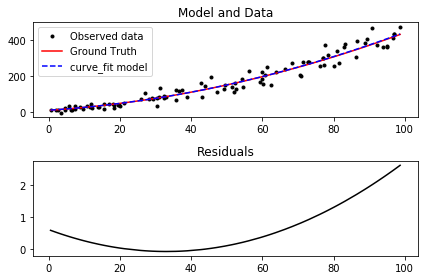

In [7]:
# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(my_polynomial,x,y_noisy,sigma=ese) 

print("Obtained parameters:")
print(popt)

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

# we calculate the best estimate
y_pred_curvefit = my_polynomial(x,*popt) # parameter unwrapping (*popt) works only in Python 3
print("Fit RMSE is: "+str(np.sum((y_pred_curvefit-y_noisy)**2)))

plt.figure()

plt.subplot(2,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"k-")
plt.title("Residuals")

plt.tight_layout()

We still find the curvature, but better.

Could we plot the objective function for visualizing it ?

In [8]:
a_ = np.linspace(9.,11.,1000)
b_ = np.linspace(0.5,2.0,1000)
c_ = 0.02978

record_misfit = np.zeros((len(a_),len(b_)))

def residual(x,y,a,b,c):
    return np.sum((y-my_polynomial(x,a,b,c))**2)

for i in range(len(a_)):
    for j in range(len(b_)):
        record_misfit[i,j] = residual(x,y_noisy,a_[i],b_[j],c_)

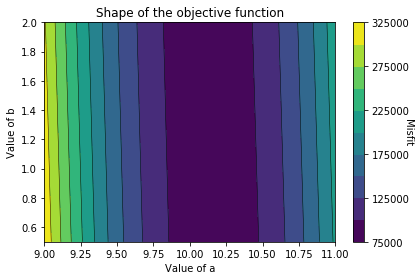

In [9]:
plt.figure()
CS = plt.contour(a_, b_, record_misfit, 10, linewidths=0.5, colors='k')
CS = plt.contourf(a_, b_, record_misfit, 10,
                  vmax=abs(record_misfit).max(), vmin=abs(record_misfit).min())
cbar = plt.colorbar()
cbar.set_label('Misfit', rotation=270)

plt.xlabel("Value of a")
plt.ylabel("Value of b")

plt.title("Shape of the objective function")

plt.tight_layout()

# Applying this to CO2 data

We first grab the CO2 data (I put them on the repo to avoid problems with the NOAA server...) and plot them, and try to fit them with different functions (polynomial and power law).

Data are at the address ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

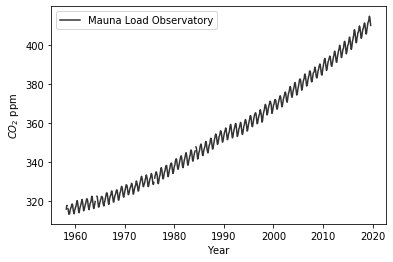

In [10]:
import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...
dat = pd.read_table('CO2_noaa_01102019.csv',
                  comment='#', sep='\s+', header=None, na_values=[-1, -99.99])

# what are the columns? 
dat.columns = ['year', 'month', 'dec_year', 'co2_av', 'co2_interp', 'co2_trend', 'days']

# let's plot those data
plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

Note that this example is a bit different from that in class as we have also the monthly record there (sinusoidal signal)

In [1]:
# let's make sure there is no NAN (missign values, happens in various geochemical records!)
dat.dropna(inplace=True)  # necessary because optimisation fails if there are NaNs in the data

NameError: name 'dat' is not defined

We built up this function incrementally - try modifying parameters and seeing what happens! For instance, you can notice the sin function that allows to fit the sinusoidal part of signal.

In [12]:
def co2_record(time, p0, p1, p2, p3, phase, amp):
    seasonal = np.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

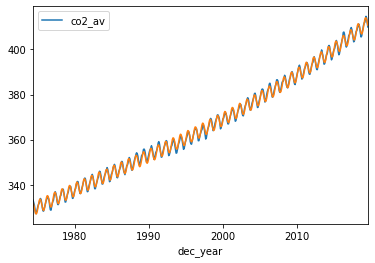

In [13]:
p, cov = curve_fit(co2_record, dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'])

ax = dat.plot('dec_year', 'co2_av')

ax.plot(dat.loc[:, 'dec_year'], co2_record(dat.loc[:, 'dec_year'], *p))

In [14]:
print("The parameters are ...")
print(p)

The parameters are ...
[-2.39616053e+06  3.62315699e+03 -1.82663812e+00  3.07096011e-04
  1.05461954e+00  2.92728802e+00]


To get the errors, remember that the standard deviations of parameters are retrieved from the covariance matrix as
$\sigma = \sqrt{diag(cov)}$

In [15]:
p_ese = np.sqrt(np.diag(cov))
print(p_ese)

[1.59016992e+05 2.38890620e+02 1.19625533e-01 1.99672338e-05
 2.73372731e-03 5.04522539e-02]


# Propagating uncertainties

You can do it with calculating them via the formula for uncertainty propagation, or use the [uncertainties](https://pythonhosted.org/uncertainties/) python package.


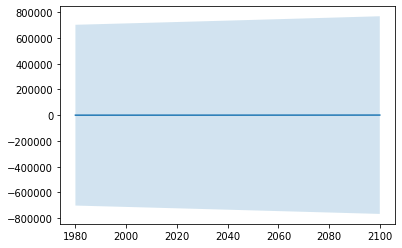

In [16]:
# loading the library
from uncertainties import unumpy as un

# we define an uncertainties array of the parameters 
# and their variance/covariance (see uncertainties documentation)
params = un.uarray(p, np.sqrt(np.diag(cov)))

# we redefine our function to work with unumpy
def co2_record_unumpy(time, p0, p1, p2, p3, phase, amp):
    seasonal = un.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# new time step
time = np.arange(1980, 2100, 0.1)
pred = co2_record_unumpy(time, *params)

plt.plot(time, un.nominal_values(pred))

plt.fill_between(time, un.nominal_values(pred) - un.std_devs(pred),
                 un.nominal_values(pred) + un.std_devs(pred), alpha=0.2, zorder=-1)

# Ouch... something is not working well..... We will see why next time!